# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Описание данных**


*Технологический процесс*

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        Xanthate **— ксантогенат (промотер, или активатор флотации);
        Sulphate — сульфат (на данном производстве сульфид натрия);
        Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

*Параметры этапов*

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]


Пример: **rougher.input.feed_ag**


*Возможные значения для блока [этап]:*

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

*Возможные значения для блока [тип_параметра]:*

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

## Подготовка данных

In [ ]:
try:
    import pandas_profiling
except:
    !pip install pandas-profiling
    import pandas_profiling

In [2]:
import glob
import math
import os
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV 

In [3]:
STATE = sum(ord(x) for x in 'NEVER SURRENDER')

TARGETS = ['rougher.output.recovery', 'final.output.recovery']

rcParams['figure.figsize'] = 15,5
pd.set_option('max_columns', None)

### Загрузка файлов и оценка информации

По маске получим имена файлов

In [4]:
file_names = glob.glob(os.path.join("/datasets", "gold_recovery*_new.csv"))
file_names

['/datasets/gold_recovery_full_new.csv',
 '/datasets/gold_recovery_test_new.csv',
 '/datasets/gold_recovery_train_new.csv']

и загрузим данные в датафреймы

In [5]:
df_train = pd.read_csv(file_names[2], index_col='date')
df_test = pd.read_csv(file_names[1], index_col='date')
df_full = pd.read_csv(file_names[0], index_col='date')

Посмотрим, какая информация содержится в тестовых и тренировочных данных:

In [1]:
#df_train.profile_report(minimal=True)

In [2]:
#df_test.profile_report(minimal=True)

Можно отметить, что
- оба датафрейма содержат небольшое количество пропущенных значений (0.3% и <0.1% в тренировочном и тестовом соответственно)
- в тестовых данных набор признаков меньше, чем в тренировочных
- некоторые из столбцов содержат выделяющиеся нулевые (или околонулевые) значения.
- некоторые из столбцов содержат единичные значения, выделяющиеся по знаку из общей массы
- все процентные значения корректны


- целевые столбцы в обучающей
    - пропущенных значений нет
    - есть нулевые значения

_________________________
Посмотрим, в каких случаях появляются нулевые значения в целевых столбцах:

In [8]:
df_train[df_train[TARGETS[0]] == 0].head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.25,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,41359.061159,3196.130244,3205.717062,2.530283,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,0.0,0.0,0.0,0.0,4.784398,0.818965,20.046797,1.939811,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,13.605154,4.983564,9.545239,3.102137,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2

In [9]:
df_train[df_train[TARGETS[1]] == 0].head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,133.610147,14.032789,7.32,1.550190,8.986696,6.530607,11.969464,26.238846,13.854131,2.156414,8.174442,1.965728,1800.648807,-349.517991,1799.347332,-350.925554,1798.833149,-349.609813,1456.714168,-350.518404,45778.313924,2952.203313,2943.136954,2.894754,7.407737,1.934178,500.087438,51.965198,31.762853,5.598971,10.251319,6.620908,10.259054,6.620118,11.803589,7.143475,21.692525,15.935190,68.960993,5.114923,0.925673,20.699912,2.293607,999.884600,-499.972731,1499.290173,-399.546180,1499.161769,-398.630471,1499.040323,-399.389036,1501.877151,-397.227473,1501.061312,-400.602849,11.838086,3.905472,10.651508,2.283842,32.054894,-400.832639,30.998499,-401.051170,30.900779,-400.953348,29.003189,-401.031397,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808
2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,111.502432,11.9278

По соседним столбцам можно предположить, что эти значения появились из-за ошибок при получении данных. Заполнение этих значений может повлиять на качество модели, удалим их.

In [10]:
for target in TARGETS:
    df_train = df_train[df_train[target] != 0]

Так же можно оценить, что были удалены строки, где нулевые данные были и в других столбцах типа `concentrate`, проверим на примере

In [11]:
df_train[df_train['final.output.concentrate_ag'] == 0].head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Нулевых значений не осталось.

_________________


Есть ряд столбцов с выделяющимися "околонулевыми" значениями. Ряд из них находится в данных типа `floatbank` - возможно, либо ошибки в записи данных, либо ошибки в работе самих установок. По возможности, такие выделяющиеся значения стоит уточнять у источника данных.


В данном случае нет возможности обработать, пока что оставим, при необходимости попробуем обработать позднее.

________________________
Т.к. известно, что близкие по дате данные могут быть похожи по значениям - можно заменить пропущенные значения с помощью метода `ffill`

In [14]:
df_train = df_train.fillna(method="ffill")

In [15]:
df_test = df_test.fillna(method="ffill")

и проверим

In [16]:
print(f'Missing in train {df_train.isna().sum().sum()}')
print(f'Missing in test {df_test.isna().sum().sum()}')

Missing in train 0
Missing in test 0


__________________
### Проверка эффективности обогащения 

Эффективность обогащения рассчитывается по формуле <br><br>
        <b>Eff = (C*(F-T)) / (F*(C-T)) * 100%</b><br><br>
где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Подставим данные в формулу:

In [17]:
F = df_train['rougher.input.feed_au']
C = df_train['final.output.concentrate_au']
T = df_train['final.output.tail_au']

eff = (C*(F-T)) / (F*(C-T)) * 100

Найдем

In [18]:
mean_absolute_error(eff, df_train['final.output.recovery'])

8.581380139526291e-15

MAE между расчитанным значением и данными практически нулевое(с учетом того, что была произведена предобработка данных и обработаны пропущенные значения, что так же могло повлиять). Можно сделать вывод, что предоставлены корректные данные и с ними можно работать и строить модель.

### Параметры тестовой выборки

Ранее было выявлено, что в тестовой выборке параметров меньше, чем в тренировочной. Посмотрим отличия.

In [19]:
df_train.columns.difference(df_test.columns).str.extract(r'(^\w*.\w*).(\w*$)')

,0,1
0,final.output,concentrate_ag
1,final.output,concentrate_au
2,final.output,concentrate_pb
3,final.output,concentrate_sol
4,final.output,recovery
5,final.output,tail_ag
6,final.output,tail_au
7,final.output,tail_pb
8,final.output,tail_sol
9,primary_cleaner.output,concentrate_ag


Можно сделать вывод, что в тестовых данных нет параметров, которые получают в процессе работы над сырьем (онлайн) и расчетных характеристик. Так же отсутствуют целевые признаки.<br>


### Вывод

В процессе подготовки данных:
- загружены данные
- удалены строки с нулевым значением целевых столбцов
- проверено, что эффективность обогащения расчитана правильно
- оценены параметры тестовой выборки и разница в параметрах с тренировочной

## Анализ данных

________________________
**Используемые функции**

In [20]:
def stage_concentrate(data: pd.DataFrame, 
                      params: str) -> None:
    # choose columns by params pattern
    name_column = data.columns[data.columns.str.contains(f'concentrate_{params}')].tolist()
    name_column.append(f'rougher.input.feed_{params}')
    name_column = name_column[::-1]
    
    #plot boxplot and line
    print('Mean concentrate')
    print(data[name_column].mean())
    data[name_column].mean().plot(marker='o', color='red')
    sns.boxplot(data=data[name_column], palette='Blues')
    plt.ylabel('Percentage')
    plt.title(f'Concentrate {params} in stages', fontsize=20)
    plt.show()
    
    #plot hist
    sns.histplot(data[name_column], element="step", alpha=.3)
    plt.xlabel('Percentage')
    plt.show()

________________

### Концентрация металлов на различных этапах

#### Золото (Au)

Mean concentrate
rougher.input.feed_au                     7.853323
rougher.output.concentrate_au            19.854799
primary_cleaner.output.concentrate_au    32.367660
final.output.concentrate_au              44.173624
dtype: float64


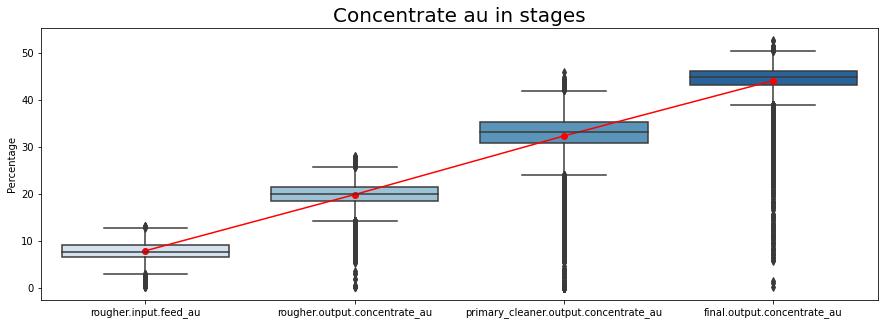

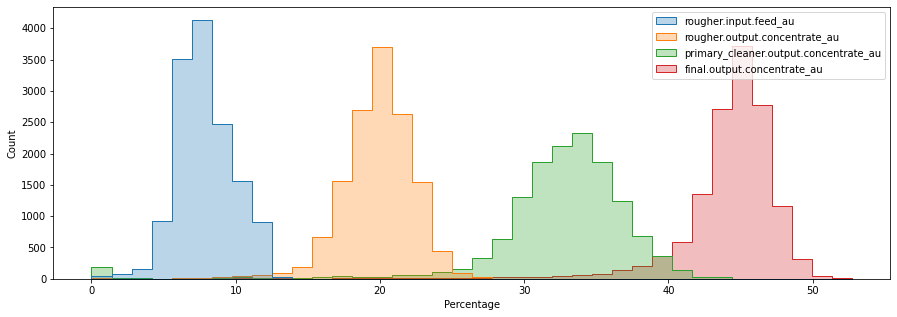

In [21]:
stage_concentrate(df_train, 'au')

#### Серебро (Ag)

Mean concentrate
rougher.input.feed_ag                     8.568726
rougher.output.concentrate_ag            12.029788
primary_cleaner.output.concentrate_ag     8.205179
final.output.concentrate_ag               5.165178
dtype: float64


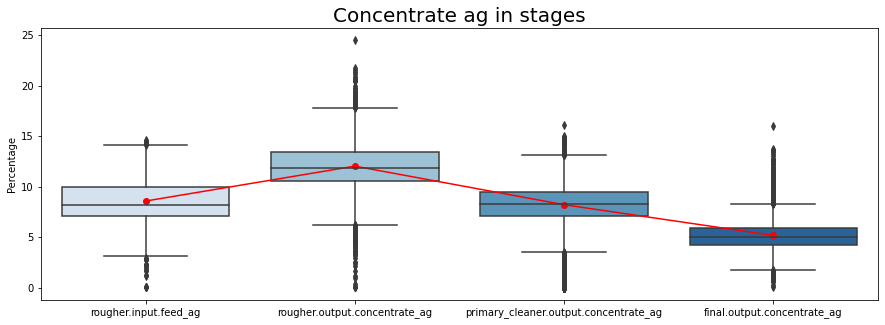

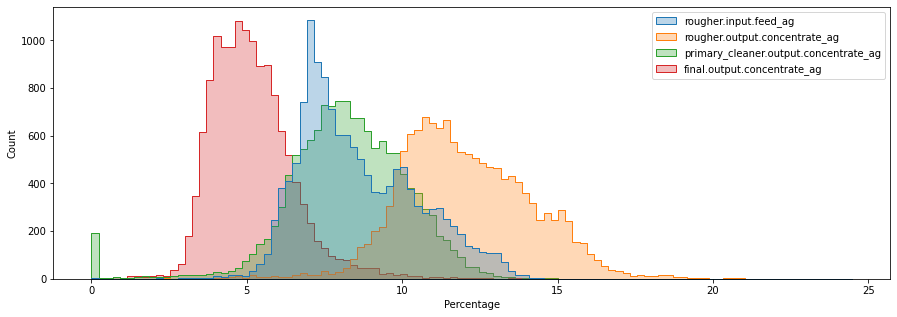

In [22]:
stage_concentrate(df_train, 'ag')

#### Свинец (Pb)

Mean concentrate
rougher.input.feed_pb                     3.499891
rougher.output.concentrate_pb             7.829981
primary_cleaner.output.concentrate_pb     9.552910
final.output.concentrate_pb              10.175150
dtype: float64


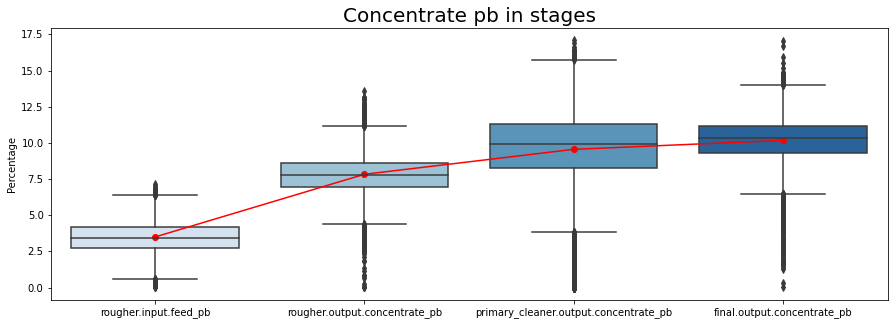

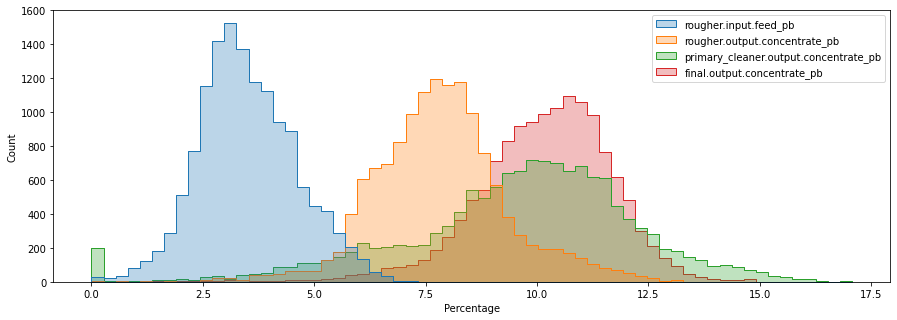

In [23]:
stage_concentrate(df_train, 'pb')

#### Вывод

- концентрация золота на каждом этапе(не считая необработанного материала) самая большая
- концентрация золота достаточно сильно растет на каждом этапе обработки (с 7.8 до 44%)
- концентрация серебра немного растет на флотации и потом падает, относительно первоначального материала падает не сильно (с 8 до 5%)
- концентрация свинца немного растет (с 3 до 10%)

_______________________
### Размер гранул


Для корректной работы модели необходимо, чтоб распределения по гранулам сырья в тестовой и тренировочной выборке не сильно отличались, проверим

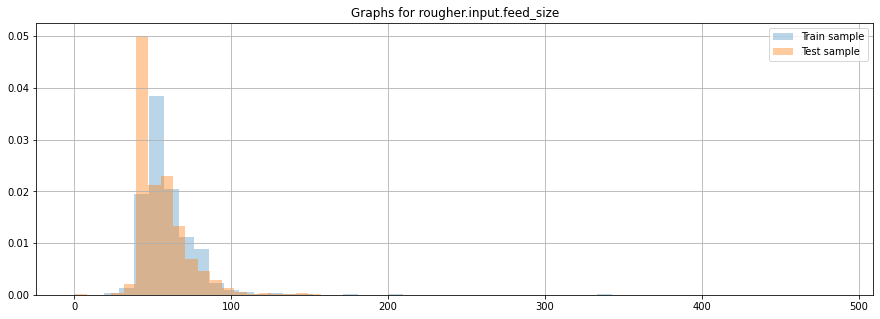

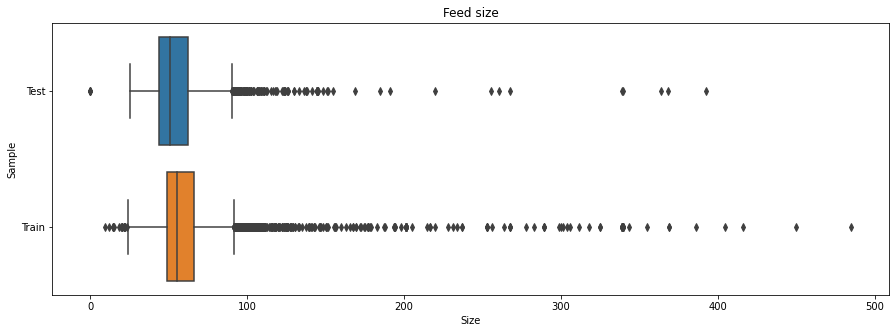

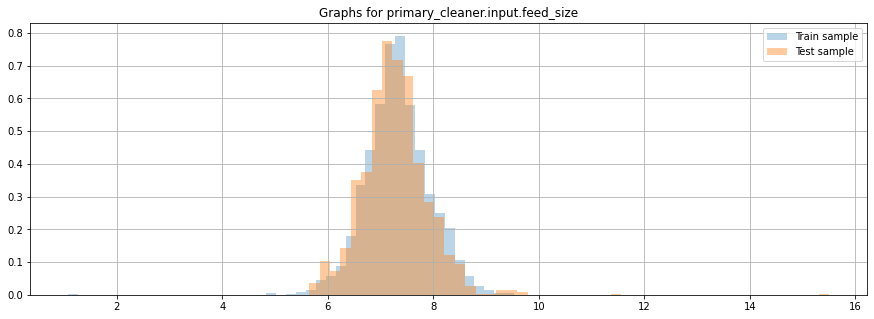

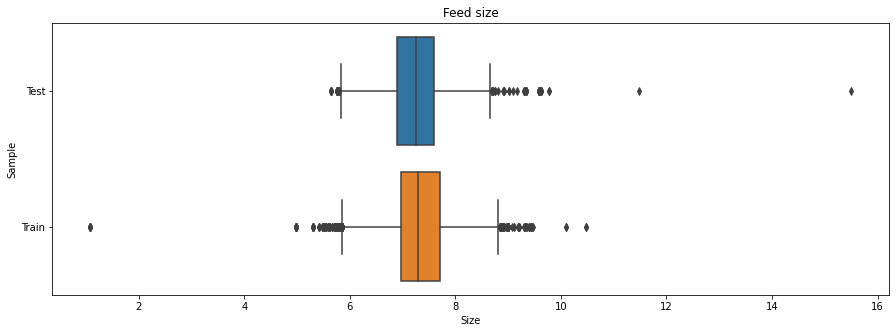

In [24]:
for name_col in ['rougher.input.feed_size','primary_cleaner.input.feed_size']:
    df_train[name_col].hist(bins=50, density=1, alpha=.3)
    df_test[name_col].hist(bins=50, density=1, alpha=.4)
    plt.legend(['Train sample','Test sample'])
    plt.title(f'Graphs for {name_col}')
    plt.show()
    
    sns.boxplot(data=[df_test[name_col],df_train[name_col]], 
                orient="h").set_yticklabels(['Test','Train'])
    plt.title('Feed size')
    plt.xlabel('Size')
    plt.ylabel('Sample')
    plt.show()

Для `rougher.input` в тестовых данных "пик" больше, но, в целом, распределение размеров гранул достаточно похожи. <br>
Для `primary_cleaner.input` отличий практически нет, но есть пара значительных выбросов. Пока оставим их.


Данные подходят для дальнейшего построения и оценки модели.

### Суммарная концентрация  веществ

Describe of sum of concentrates in rougher.input.feed
quant(.01) 34.348614
count    13795.000000
mean        56.219933
std          6.989913
min          0.040000
25%         52.538724
50%         56.619236
75%         60.760588
max         74.458253
Name: rougher.input.feed.sum, dtype: float64
_________
Describe of sum of concentrates in rougher.output.concentrate
quant(.01) 39.610139
count    13795.000000
mean        68.615688
std          8.096082
min          0.040000
25%         65.248019
50%         69.310903
75%         73.508255
max         88.140119
Name: rougher.output.concentrate.sum, dtype: float64
_________
Describe of sum of concentrates in final.output.concentrate
quant(.01) 45.210955
count    13795.000000
mean        68.664585
std          5.432306
min          0.040000
25%         67.559772
50%         69.136193
75%         70.953745
max         80.210644
Name: final.output.concentrate.sum, dtype: float64
_________


/opt/conda/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


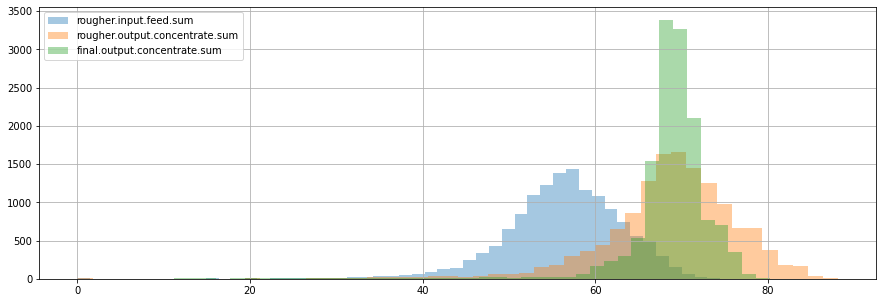

In [25]:
col_names_sum = []
for itm in ['rougher.input.feed','rougher.output.concentrate','final.output.concentrate']:
    print(f'Describe of sum of concentrates in {itm}')
    col_names_sum.append(f'{itm}.sum')
    pattern = f'{itm}_(ag|pb|sol|au)$'
    col_names = df_train.columns[df_train.columns.str.contains(pattern)]
    df_train[f'{itm}.sum'] = df_train[col_names].sum(axis=1)
    df_train[f'{itm}.sum'].hist(bins=50, alpha=.4)
    print(f'quant(.01) {df_train[f"{itm}.sum"].quantile(.01):.6f}')
    print(df_train[f'{itm}.sum'].describe())
    print('_________')
plt.legend(col_names_sum);

Выявленные аномальные значения (суммарная концентрация веществ около нуля) может говорить об ошибочных данных, сбоях в оборудовании и т.п., т.е. могут быть проблемы и в других столбцах. Удалим эти записи.

In [26]:
for name in col_names_sum:
    df_train = df_train[df_train[name] > df_train[name].quantile(.01)]

И посмотрим сумму концентраций снова

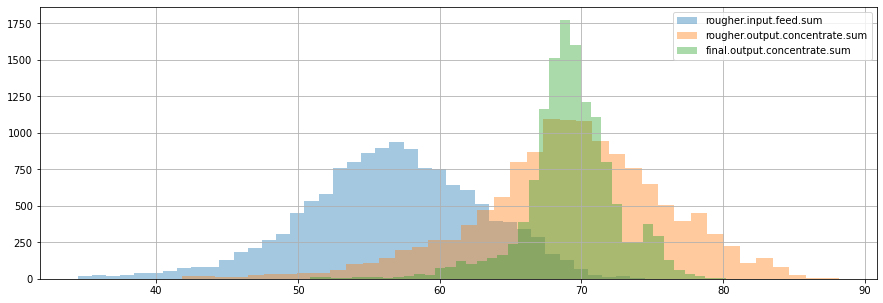

In [27]:
for name in col_names_sum:
    df_train[name].hist(bins=40, alpha=.4)
plt.legend(col_names_sum);

Аномалии убраны, можно оценить, что суммарная концентрация отслеживаемых веществ в необработанном сырье минимальна и распределение более "плавное". При обработке суммарная концентрация повышается и график распределения "сужается".

### Вывод

В процессе анализа данных были изучены 
- концентрации золота, серебра и свинца в зависимости от стадии обработки
    - концентрация золота на каждом этапе(не считая необработанного материала) самая большая
    - концентрация золота достаточно сильно растет на каждом этапе обработки (с 7.8 до 44%)
    - концентрация серебра немного растет на флотации и потом падает, относительно первоначального материала падает не сильно (с 8 до 5%)
    - концентрация свинца немного растет (с 3 до 10%)    
- суммарная концентрация отслеживаемых веществ, где в зависимости от стадии обработки общая концентрация полезных веществ повышается и разброс уменьшается
- распределение размеров гранул в тестовой и обучающей выборках 
    - распределения приблизительно похожи, что позволяет строить модель и предсказывать значения для тестовой выборки

## Модель

**Используемые функции**

In [28]:
#metrics
def s_mape(real: np.array, 
           pred: np.array) -> float:
    sums = sum(2 * np.abs(real - pred) / (np.abs(real) + np.abs(pred)))
    return sums * 100 / len(real)

In [29]:
#metrics full
def res_s_mape(rougher: float, 
               final: float) -> float:
    return 0.25 * rougher + 0.75 * final

In [30]:
s_mape_scorer = make_scorer(s_mape, greater_is_better=False)

In [31]:
def create_model(model_name: str, 
                 data: namedtuple, 
                 target_name: str,
                 parametrs: dict = {},
                 **kwargs): 
    #create model
    if model_name in ['LinearRegression', 'BayesianRidge']:
        model = eval(model_name)(**kwargs)
    else:
        model = eval(model_name)(random_state=STATE, **kwargs)
    
    #use GridSearchCV
    grid = GridSearchCV(model, parametrs, cv=6, scoring=s_mape_scorer)
    grid.fit(data.features, data.target)
    score_ = abs(grid.best_score_)
    #print(f'SMape {target_name} = {score_:.4f}')
    #print(f'Gyperparams {grid.best_params_}')
    return [target_name, model_name, score_, grid.best_params_]
    

_____________________

Перед нами стоит регрессионная задача. <br>
Будем использовать три алгоритма:
- DecisionTreeRegressor (дерево решений) - будем использовать с различной глубиной дерева (max_depth), минимальным количеством элементов выборки(min_samples_split)
- RandomForestRegressor (случайный лес) - будем использовать с различной глубиной дерева (max_depth), количеством элементов выборки(min_samples_split) и количеством деревьев(n_estimators)
- LinearRegression (линейная регрессия) и BayesianRidge (Байесовская регрессия)


Для подбора гиперпараметров существуют специальные фреймворки, например, Optuna, но в данном проекте будем использовать модуль из sklearn - **GridSearchCV**, в который встроена кросс-валидация.

____________________________________
Выделим признаки и целевой признак. Т.к. один из целевых признаков отвечает за этап `rougher` логично для обучения отобрать признаки, которые известны до начала этого этапа обработки.

In [33]:
train_r = namedtuple('features', 'target')
train = namedtuple('features', 'target')

In [34]:
train.features = df_train[df_test.columns]
train.target = df_train[TARGETS[1]]

In [35]:
train_r.features = df_train[df_test.columns[df_test.columns.str.contains('rougher')]]
train_r.target = df_train[TARGETS[0]]

In [36]:
result = []

Зададим список гиперпараметры для каждой модели для гридсерча

In [37]:
dtr_params = {'max_depth': range(2,13,5), 
              'min_samples_split': [20, 100]}

rfr_params = {'max_depth': range(2,13,5), 
              'min_samples_split' : [20, 100],
              'n_estimators': [2, 10]    #[*range(2, 9, 3), 15, 60, 100]
             }

lr_params = {'normalize': [True, False]}

### Построение модели

**Дерево решений**

In [38]:
%%time
# все модели минут 5 в сумме
#rougher
result.append(create_model('DecisionTreeRegressor', train_r, TARGETS[0], parametrs=dtr_params))

CPU times: user 4.87 s, sys: 33.6 ms, total: 4.9 s
Wall time: 4.91 s


In [39]:
%%time
#final
result.append(create_model('DecisionTreeRegressor', train,  TARGETS[1], parametrs=dtr_params))

CPU times: user 10.6 s, sys: 72.7 ms, total: 10.7 s
Wall time: 10.7 s


**Случайный лес**

In [40]:
%%time
#rougher
result.append(create_model('RandomForestRegressor', train_r,  TARGETS[0], parametrs=rfr_params))

CPU times: user 33 s, sys: 110 ms, total: 33.2 s
Wall time: 33.2 s


In [41]:
%%time
#final
result.append(create_model('RandomForestRegressor', train,  TARGETS[1], parametrs=rfr_params))

CPU times: user 1min 18s, sys: 219 ms, total: 1min 19s
Wall time: 1min 19s


**Линейная регрессия**

In [42]:
%%time
#rougher
result.append(create_model('LinearRegression', train_r,  TARGETS[0], parametrs=lr_params))

CPU times: user 773 ms, sys: 1.63 s, total: 2.4 s
Wall time: 2.36 s


In [43]:
%%time
#final
result.append(create_model('LinearRegression', train,  TARGETS[1], parametrs=lr_params))

CPU times: user 966 ms, sys: 2.49 s, total: 3.46 s
Wall time: 3.41 s


**Байесовская регрессия**

In [44]:
%%time
#rougher
result.append(create_model('BayesianRidge', train_r,  TARGETS[0], parametrs=lr_params))

CPU times: user 797 ms, sys: 2.71 s, total: 3.5 s
Wall time: 3.5 s


In [45]:
%%time
#final
result.append(create_model('BayesianRidge', train,  TARGETS[1], parametrs=lr_params))

CPU times: user 2.06 s, sys: 4.5 s, total: 6.56 s
Wall time: 6.6 s


Посмотрим получившиеся результаты

In [46]:
pd.DataFrame(result, columns=['target', 'model', 'smap', 'hyperparams'])

,target,model,smap,hyperparams
0,rougher.output.recovery,DecisionTreeRegressor,7.194747,"{'max_depth': 7, 'min_samples_split': 100}"
1,final.output.recovery,DecisionTreeRegressor,9.354336,"{'max_depth': 2, 'min_samples_split': 20}"
2,rougher.output.recovery,RandomForestRegressor,6.911798,"{'max_depth': 7, 'min_samples_split': 100, 'n_..."
3,final.output.recovery,RandomForestRegressor,8.834608,"{'max_depth': 7, 'min_samples_split': 100, 'n_..."
4,rougher.output.recovery,LinearRegression,5.987832,{'normalize': True}
5,final.output.recovery,LinearRegression,10.624917,{'normalize': True}
6,rougher.output.recovery,BayesianRidge,5.963045,{'normalize': True}
7,final.output.recovery,BayesianRidge,10.493995,{'normalize': True}


Для `rougher.output.recovery` лучший результат (**5.963045**) показала модель BayesianRidge ({'normalize': True}) <br>
Для `final.output.recovery` лучший результат (**8.834608**) RandomForestRegressor ({'max_depth': 7, 'min_samples_split': 100, 'n_estimators': 10})

Итоговое sMAPE:

In [47]:
res_s_mape(5.963045, 8.834608)

8.116717249999999

### Проверка модели на тестовых данных

Первоначально предположим, что для тестовых данных нет истинных значений:

In [48]:
df_test_r = df_test[df_test.columns[df_test.columns.str.contains('rougher')]]

**`rougher.output.recovery`**

In [49]:
rougher_model = BayesianRidge(normalize=True)
rougher_model.fit(train_r.features, train_r.target)
test_rougher = pd.Series(rougher_model.predict(df_test_r))

**`final.output.recovery`**

In [50]:
final_model = RandomForestRegressor(random_state=STATE, max_depth=7, min_samples_split=100, n_estimators=10)
final_model.fit(train.features, train.target)
test_final = pd.Series(final_model.predict(df_test))

Т.к. пока что "реальных" данных нет, можно проверить полученные данные на базовую адекватность:
- нет значений, выходящих за логические границы (менее 0 и более 100)
- "область" предсказанных значений совпадает с имеющимися тренировочными (границы ожидаемых результатов)

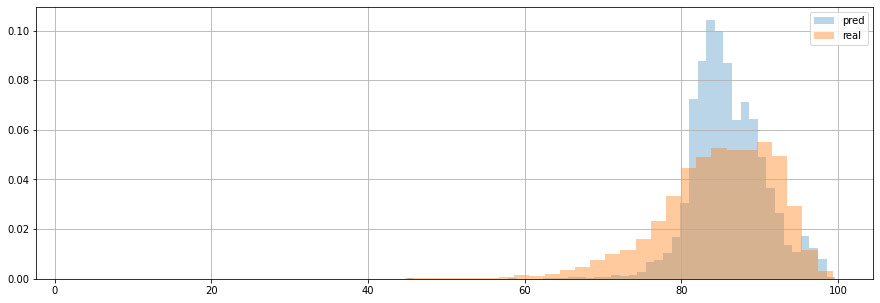

In [51]:
test_rougher.hist(bins=50, density=1, alpha=.3)
train_r.target.hist(bins=50, density=1, alpha=.4)
plt.legend(['pred','real']);

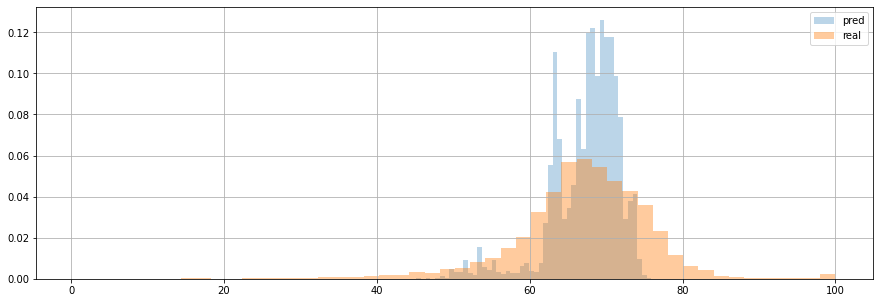

In [52]:
test_final.hist(bins=50, density=1, alpha=.3)
train.target.hist(bins=50, density=1, alpha=.4)
plt.legend(['pred','real']);

Для всех предсказанных значений аномальных значений нет, области совпадают с ожидаемыми. Можно предположить, что полученные предсказания корректны.


Теперь из полного датафрейма получим реальные значения для тестовой выборки.

In [53]:
real_rougher = df_full.loc[df_test.index][TARGETS[0]].reset_index(drop=True)
real_final = df_full.loc[df_test.index][TARGETS[1]].reset_index(drop=True)

In [54]:
smape_rougher = s_mape(real_rougher, test_rougher)
print(f'sMAPE for rougher.output.recovery: {smape_rougher}')
smape_final = s_mape(real_final, test_final)
print(f'sMAPE for final.output.recovery: {smape_final}')
print(f'Final sMAPE {res_s_mape(smape_rougher,smape_final)}')

sMAPE for rougher.output.recovery: 8.184949411387173
sMAPE for final.output.recovery: 9.910791911763338
Final sMAPE 9.479331286669296


Изменение метрик относительно полученных при построении модели допустимо, модель для предсказания `rougher.output.recovery` со своей задачей справилась хуже.

### Проверка на адекватность


In [55]:
dummy_mean_r = DummyRegressor(strategy = 'mean').fit(train_r.features, train_r.target)
dummy_mean_f = DummyRegressor(strategy = 'mean').fit(train.features, train.target)

In [56]:
dummy_pred_r = dummy_mean_r.predict(df_test_r)
dummy_pred_f = dummy_mean_f.predict(df_test)

In [57]:
smape_rougher = s_mape(real_rougher, dummy_pred_r)
print(f'sMAPE for rougher.output.recovery: {smape_rougher}')
smape_final = s_mape(real_final, dummy_pred_f)
print(f'sMAPE for final.output.recovery: {smape_final}')
print(f'Final sMAPE {res_s_mape(smape_rougher,smape_final)}')

sMAPE for rougher.output.recovery: 8.9808404111124
sMAPE for final.output.recovery: 10.012788969374501
Final sMAPE 9.754801829808976


Все значения метрик константной модели выше, чем метрики выбранных моделей. Это значит, что выбранные модели имеют право на жизнь.

## Вывод

В процессе работы были получены и изучены данные по процессу получения золота из золотосодержащей руды.
- проведена проверка, что эффективность обогащения указана верно
- проведена доступная обработка пропущенных и аномальных значений
- выделены признаки для прогнозирования


Проведен анализ данных
- исследована концентрация металлов на различных этапах очистки
- проведена проверка, что основные параметры (размер гранул) для тренировочной выборки и данных для прогнозирования совпадают
- исследована суммарная концентрация отслеживаемых веществ на различных этапах


Построены модели (метрика качества sMAPE)
- DecisionTreeRegressor
- RandomForestRegressor
- LinearRegression 
- BayesianRidge 

для нахождения целевых параметров
- эффективность обогащения чернового концентрата rougher.output.recovery
- эффективность обогащения финального концентрата final.output.recovery

Были выбраны модели
- для `rougher.output.recovery` модель BayesianRidge (гиперпараметры {'normalize': True}) с sMAPE = **5.963045** (на тестовых данных **8.1849494**)
- для `final.output.recovery` модель RandomForestRegressor (гиперпараметры  {'max_depth': 7, 'min_samples_split': 100, 'n_estimators': 10})  с sMAPE = **8.834608** (на тестовых данных  **10.012789**)
- финальный sMAPE = **8.1167** (на тестовых данных **9.47933**)



Полученные от метрик "наивной" модели отличаются совсем не так сильно, как хотелось бы, но все же имеют право на жизнь и дальнйшее улучшение.


**Рекомендации**
- для улучшений качества модели получить у источника данных сведения про аномальные значения в данных, в особенности аномальные значения  в параметрах типа `floatbank` - нормальны аномальные значения и как их интерпретировать.
- текущие модели использовать с осторожностью